In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

np.random.seed(555)

#### **数据处理**
##### 数据集来源为Movielens-1M
##### 从movies.dat获取电影属性，从ratings.dat获取评分数据，从users.dat获取用户属性
##### 选择属性“gender”,“age”,"occupation","year"作为输入
##### 对获得的数据划分训练集和测试集，其中训练集占比为0.8，之后进行训练得到结果

In [2]:
 def get_users_attr(df_users):
    df_users = pd.read_csv(users_path,sep="::",names=['uid','gender','age','occupation','zipcode'],encoding='utf-8')
    user_ids=set(df_users['uid'].values)
    df_users = df_users.drop(['zipcode'],axis=1)
    df_users = pd.get_dummies(df_users,columns=['gender','age','occupation'])
    return df_users,user_ids

In [3]:
def get_movies_attr(df_movies):
    year=df_movies['title'].values
    for i in range(len(year)):
        year[i]=year[i].split('(')[-1].split(')')[0]
    df_movies['year']=year
    genres_list = set()
    for sstr in df_movies['genres'].str.split('|'):
        genres_list = set().union(sstr, genres_list)
    genres_list = list(genres_list)
    for genres in genres_list:
        df_movies[genres] = df_movies['genres'].str.contains(genres).apply(lambda x:1 if x else 0)
    item_ids=set(df_movies['iid'].values)
    df_movies = df_movies.drop(['title','genres'],axis=1)
    df_movies = pd.get_dummies(df_movies,columns=['year'])
    return df_movies,item_ids

In [4]:
class DataProcess:
    def __init__(self, ratings_path, users_path, movies_path, alpha=0.8):
        print("start load data")
        df_ratings=pd.read_csv(ratings_path,sep="::",names=['uid', 'iid', 'ratings','time'],encoding='utf-8',engine='python')
        df_users=pd.read_csv(users_path,sep="::",names=['uid', 'gender', 'age','occupation','zipcode'],encoding='utf-8',engine='python')
        df_movies=pd.read_csv(movies_path,sep="::",names=['iid', 'title', 'genres'],encoding='ISO-8859-1',engine='python')
        print("start process data")
        df_ratings=df_ratings.drop('time',axis=1)
        df_users,user_ids=get_users_attr(df_users)
        df_movies,item_ids=get_movies_attr(df_movies)
    
        self.n_user=len(user_ids)
        self.n_item=len(item_ids)
        print("Number of users = {} , Number of items = {}".format(self.n_user,self.n_item))
        u_id2idx = dict(zip(user_ids, range(self.n_user)))
        i_id2idx = dict(zip(item_ids, range(self.n_item)))
        
        df_ratings = df_ratings.assign(uid=[u_id2idx[uid] for uid in df_ratings.uid])
        df_ratings = df_ratings.assign(iid=[i_id2idx[iid] for iid in df_ratings.iid])
        df_ratings = df_ratings.loc[df_ratings['uid']<=100]
        df_ratings = df_ratings.loc[df_ratings['iid']<=100]
        self.df = pd.merge(pd.merge(df_ratings, df_users, on='uid'), df_movies, on='iid')
        #print(self.df.info())
        self.df = pd.get_dummies(self.df,columns=['uid','iid'])
        self.X = self.df.drop('ratings', axis=1).values
        self.Y = self.df['ratings'].values

#### **FM**
##### 模型如下

In [5]:
class FactorizationMachine():
    def __init__(self, k=5, lr=0.01, iterations=100): 
        self.w0 = None 
        self.w = None 
        self.v = None 
        self.k = k 
        self.lr = lr
        self.iterations = iterations
        self.losses = []
        
        
    def FM_cul(self, x):
        inter2 = np.sum((x.dot(self.v)) ** 2 - (x ** 2).dot(self.v ** 2)) 
        y = self.w0 + x.dot(self.w) + inter2 / 2  
        return y[0]
        
        
    def train(self, X, Y):
        m, n = np.shape(X)
        self.w0 = 0
        self.w = np.random.uniform(size=(n, 1))
        self.v = np.random.uniform(size=(n, self.k)) 
        
        for it in range(self.iterations):
            loss = 0  
            for i in range(m):  
                y = self.FM_cul(x=X[i])  
                loss += pow(Y[i]-y,2)  #计算损失函数值
                dloss_w0 = -2*(Y[i]-y)# 对w0求导
                self.w0 = self.w0 - self.lr * dloss_w0 
                for j in range(n): 
                    if X[i][j] > 0:
                        dloss_wj = dloss_w0 * X[i][j]  # 对wj求导
                        self.w[j] = self.w[j] - self.lr * dloss_wj 
                        for f in range(self.k):  # 对vjf求导
                            dloss_vjf = dloss_wj * (X[i].dot(self.v[:, f]) - self.v[j, f] * X[i, j])
                            self.v[j][f] = self.v[j][f] - self.lr * dloss_vjf 
                            
            self.losses.append(loss/m)
            if it % 10==0:
                print("iter :{}| loss :{:.4f}".format(it, loss/m))
                
    def evaluate(self, X, Y):
        Y_predict=[]
        m=X.shape[0]
        for i in range(m):  # 遍历测试集
            y = self.FM_cul(x=X[i])  # FM的模型方程 
            Y_predict.append(y)
        mae=sum(np.fabs(Y-Y_predict))/m
        rmse=np.sqrt(sum((Y-Y_predict)**2)/m)
        print("test mae :{:.4f} test rmse :{:.4f}".format(mae,rmse))        
    

#### **数据导入及处理**

In [6]:
ratings_path="../input/movielens-1m-dataset/ratings.dat"
users_path="../input/movielens-1m-dataset/users.dat"
movies_path="../input/movielens-1m-dataset/movies.dat"
dp = DataProcess(ratings_path,users_path,movies_path)
X_train,X_test,Y_train,Y_test=train_test_split(dp.X, dp.Y, test_size=0.2, random_state=123)

start load data
start process data
Number of users = 6040 , Number of items = 3883


/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


#### **训练&预测**
##### 使用MAE和RMSE进行评估

In [7]:
md=FactorizationMachine(k=10, lr=0.001, iterations=200)
md.train(X_train, Y_train)

iter :0| loss :41.0644
iter :10| loss :0.9337
iter :20| loss :0.5788
iter :30| loss :0.4299
iter :40| loss :0.3412
iter :50| loss :0.2794
iter :60| loss :0.2326
iter :70| loss :0.1953
iter :80| loss :0.1647
iter :90| loss :0.1394
iter :100| loss :0.1182
iter :110| loss :0.1004
iter :120| loss :0.0856
iter :130| loss :0.0732
iter :140| loss :0.0628
iter :150| loss :0.0542
iter :160| loss :0.0469
iter :170| loss :0.0409
iter :180| loss :0.0357
iter :190| loss :0.0314


In [8]:
md.evaluate(X_test, Y_test)

test mae :1.3045 test rmse :1.6949


#### **输出训练过程中loss的变化**

Text(0, 0.5, 'loss')

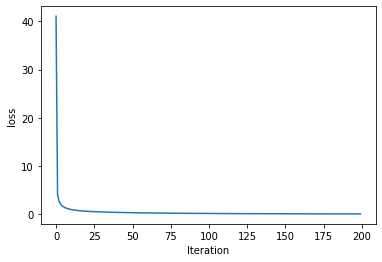

In [9]:
plt.plot(md.losses)
plt.xlabel('Iteration')
plt.ylabel('loss')